# Introduction

In this project, we aim to build a machine learning model to predict the future prices of selected stocks in the stock market. Stock price prediction is a challenging task due to the volatile and non-linear nature of financial markets. By leveraging historical stock data and applying various machine learning techniques, we hope to uncover patterns that can help forecast future price movements.

We will use publicly available stock data, perform exploratory data analysis, preprocess the data, and experiment with different machine learning algorithms such as Linear Regression, Random Forest, and LSTM neural networks. The goal is to evaluate the performance of these models and identify the most effective approach for stock price prediction.

This project will provide insights into the process of building predictive models for financial time series data and highlight the challenges and considerations involved in stock market forecasting.

In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
intc = yf.Ticker("INTC")
intc_df = intc.history(period="35y")

In [21]:
intc_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-10-08 00:00:00-04:00,0.579347,0.588059,0.564101,0.570635,25804800,0.0,0.0
1990-10-09 00:00:00-04:00,0.553211,0.557567,0.522719,0.527075,64092800,0.0,0.0
1990-10-10 00:00:00-04:00,0.527075,0.544499,0.514007,0.518363,58214400,0.0,0.0
1990-10-11 00:00:00-04:00,0.518363,0.522719,0.487871,0.507473,105171200,0.0,0.0
1990-10-12 00:00:00-04:00,0.505295,0.522719,0.492227,0.522719,105232000,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-01 00:00:00-04:00,33.529999,36.060001,33.500000,35.939999,162649700,0.0,0.0
2025-10-02 00:00:00-04:00,35.759998,37.570000,35.439999,37.299999,149361700,0.0,0.0
2025-10-03 00:00:00-04:00,37.950001,38.080002,36.450001,36.830002,125359300,0.0,0.0


In [22]:
del intc_df['Dividends']
del intc_df['Stock Splits']

<Axes: xlabel='Date'>

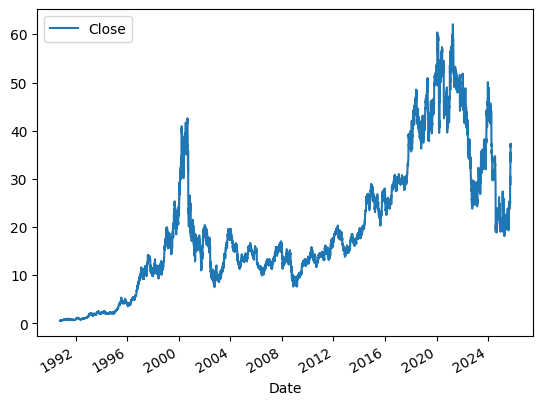

In [23]:
intc_df.plot(y='Close', use_index=True)

In [24]:
intc_df['tomorrow'] = intc_df['Close'].shift(-1)

In [25]:
intc_df['target'] = (intc_df['tomorrow'] > intc_df['Close']).astype(int)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [27]:
train = intc_df.iloc[:-100]
test = intc_df.iloc[-100:]

X_train = train[['Open', 'High', 'Low', 'Close', 'Volume']]
y_train = train['target']
X_test = test[['Open', 'High', 'Low', 'Close', 'Volume']]
y_test = test['target']
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [28]:
import sklearn.metrics as predictionscore

preds = pd.Series(preds, index=y_test.index)
predictionscore.precision_score(y_test, preds)

0.35294117647058826

<Axes: xlabel='Date'>

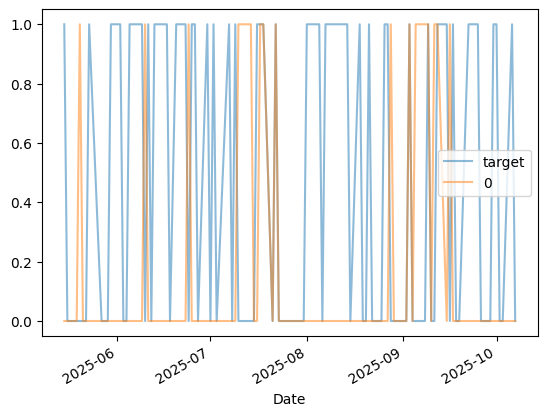

In [30]:
combined = pd.concat([y_test, preds], axis=1)
combined.plot(y=['target', 0], use_index=True, alpha=0.5)

In [48]:
import numpy as np


def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

In [40]:
def backtest(data, model, predictors, start=1000, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        preds = predict(train, test, predictors, model)
        all_predictions.append(preds)
    return pd.concat(all_predictions)

In [49]:
predictions = backtest(intc_df, model, ['Open', 'High', 'Low', 'Close', 'Volume'])

In [50]:
predictions['predictions'].value_counts()

predictions
0    4176
1    3638
Name: count, dtype: int64

In [51]:
prescision = predictionscore.precision_score(predictions['target'], predictions['predictions'])
print(f'Prescision: {prescision:.3f}')

Prescision: 0.518


In [52]:
horizons = [2, 5, 10, 21, 42, 63, 126, 252]
new_pred = []

for horizon in horizons:
    rolling_avg = intc_df['Close'].rolling(horizon).mean()
    ratio_col = f'ratio_{horizon}'
    intc_df[ratio_col] = intc_df['Close'] / rolling_avg
    trend_col = f'trend_{horizon}'
    intc_df[trend_col] = intc_df.shift(1).rolling(horizon).sum()['target']
    new_pred += [ratio_col, trend_col]

In [54]:
intc_df.dropna(inplace=True)

In [55]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [56]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds > 0.6] = 1
    preds[preds <= 0.6] = 0
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

In [57]:
predictions = backtest(intc_df, model, ['Open', 'High', 'Low', 'Close', 'Volume'] + new_pred)

In [58]:
predictions['predictions'].value_counts()

predictions
0.0    7142
1.0     419
Name: count, dtype: int64

In [59]:
prescision = predictionscore.precision_score(predictions['target'], predictions['predictions'])
print(f'Prescision: {prescision:.3f}')

Prescision: 0.492
